<a href="https://colab.research.google.com/github/Daryldactyl/Unsupervised_NeuralNet/blob/main/FraudPrediction_CC_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self Organizing Map

### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing the Dataset

In [2]:
#Dataset taken from UCI Machine Learning Repository "Statlog (Australian Credit Approval) Data Set"
df = pd.read_csv("https://raw.githubusercontent.com/Daryldactyl/Unsupervised_NeuralNet/Files/Credit_Card_Applications.csv")
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [3]:
#Not truly an x or y, only trying to make a distinction. So the Mapping can prioritize customers who got 1 in the class column meaning their CC was approved but could be fraud
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

### Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
x = sc.fit_transform(x)

### Training the SOM

In [5]:
# Used the minisom library from JustGlowing on Github
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)
som.random_weights_init(x)
som.train_random(data=x, num_iteration=100)

### Visualizing the results

In [6]:
from pylab import bone, pcolor, colorbar, plot, show

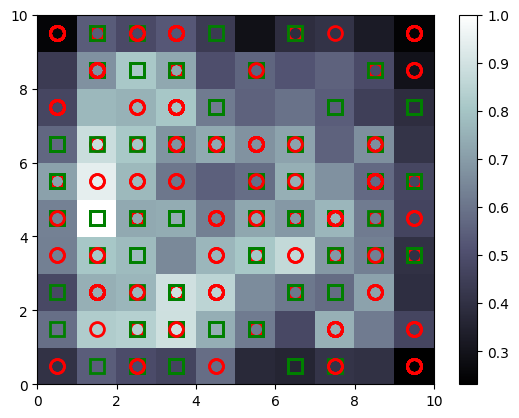

In [7]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, n in enumerate(x):
  w = som.winner(n)
  plot(w[0] + 0.5,
       w[1] + 0.5,
       markers[y[i]],
       markeredgecolor = colors[y[i]],
       markerfacecolor = 'None',
       markersize = 10,
       markeredgewidth = 2)
show()

Green boxes show customers who got approval on the CC and red is for customers who did not get approved. The white boxes above mean they have the highest interneural distance from expected which likely identifies fraud. We are trying to identify white boxes with green squares in them as they are customers who likely were fraudulently approved

## Finding the Frauds

In [40]:
#Finding the Frauds
mappings = som.win_map(x)
frauds = np.concatenate((mappings[(1,4)], mappings[(3,2)]), axis = 0)
frauds = pd.DataFrame(sc.inverse_transform(frauds))

In [41]:
#Visualize the Dataframe
frauds.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.886642,43.412883,5.805999,1.775645,7.372464,6.530481,3.477439,0.527570,0.922257,7.259415,0.472844,1.928986,270.03173,1695.207860,0.447412
1,0.794210,43.412883,5.425988,1.790994,7.372464,5.917906,3.477439,0.577253,0.922257,7.259415,0.502589,1.928986,270.03173,1226.638539,0.444928
2,0.784913,43.412883,6.447829,1.799282,7.372464,5.917906,3.477439,0.524678,0.922257,7.259415,0.465407,1.928986,270.03173,1148.543652,0.450826
3,0.739751,43.412883,5.725210,1.808260,7.372464,6.530481,3.477439,0.615195,0.922257,7.259415,0.465407,1.928986,270.03173,1567.652878,0.444928
4,0.932708,43.412883,6.716380,1.774955,7.372464,5.458474,3.477439,0.531951,0.922257,7.259415,0.480280,1.928986,270.03173,1539.018087,0.449897
5,1.004947,43.412883,6.946781,1.771118,7.372464,6.530481,5.149482,0.553857,0.922257,7.259415,0.517461,1.928986,270.03173,1278.701797,0.446791
6,1.110099,43.412883,5.800015,1.977705,9.212761,5.917906,3.477439,0.623957,0.922257,2.400000,0.457971,2.227582,270.03173,2286.125838,0.447412
7,1.130632,43.412883,5.325749,1.927823,9.212761,5.764762,3.477439,0.575763,0.922257,2.400000,0.457971,2.227582,270.03173,1018.385507,0.444928
8,1.067636,43.412883,5.469375,1.828060,9.212761,5.764762,3.895450,0.527570,0.922257,2.400000,0.457971,2.227582,270.03173,1434.891571,0.444928
9,1.109242,43.412883,5.768597,1.776259,9.212761,5.458474,3.477439,0.531162,0.922257,2.400000,0.457971,2.227582,270.03173,1539.018087,0.444928


# Part 2 Going from Unsupervised to Supervised Deep Learning

### Creating the Marix of Features

In [42]:
#Create the independent variables (features)
customers = df.iloc[:, 1:].values

In [43]:
#Create the dependent variable
is_fraud = np.zeros(len(df))
for i in range(len(df)):
  if df.iloc[i,0] in frauds:
    is_fraud[i] = 1

## Artificial Neural Network

### Normalize the features

In [44]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

### Build the ANN Architecture

In [45]:
from keras.models import Sequential
from keras.layers import Dense
ann = Sequential()
ann.add(Dense(units=2, kernel_initializer='uniform', activation='relu', input_dim = 15))
ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(customers, is_fraud, batch_size=1, epochs=5)

Epoch 1/5
690/690 [==============================] - 2s 2ms/step - loss: 0.4453 - accuracy: 0.9986
Epoch 2/5
690/690 [==============================] - 1s 2ms/step - loss: 0.1343 - accuracy: 1.0000
Epoch 3/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 1.0000
Epoch 4/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0113 - accuracy: 1.0000
Epoch 5/5
690/690 [==============================] - 1s 2ms/step - loss: 0.0050 - accuracy: 1.0000


Predict the probability of Fraud

In [73]:
y_pred = ann.predict(customers)

22/22 [==============================] - 0s 3ms/step


In [74]:
y_pred = np.concatenate((df.iloc[:, 0:1].values, y_pred), axis=1)
y_pred = y_pred[y_pred[:, 1].argsort()]
y_pred

array([[1.57238270e+07, 8.03108909e-04],
       [1.57055060e+07, 9.53551207e-04],
       [1.55830670e+07, 9.63744766e-04],
       ...,
       [1.55988020e+07, 6.10183552e-02],
       [1.56214230e+07, 8.38252530e-02],
       [1.57901130e+07, 2.64144033e-01]])